In [1]:
import collections

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

import contextlib

%matplotlib inline

In [2]:
tf.__version__

'0.9.0'

# Load MNIST

In [3]:
mnist = input_data.read_data_sets('mnist', one_hot=True)
image_size = 28 * 28
num_classes = 10
assert mnist.train.images.shape[1] == image_size
assert mnist.train.labels.shape[1] == num_classes

Extracting mnist/train-images-idx3-ubyte.gz
Extracting mnist/train-labels-idx1-ubyte.gz
Extracting mnist/t10k-images-idx3-ubyte.gz
Extracting mnist/t10k-labels-idx1-ubyte.gz


# Linear Logistic Regression
References
- [MNIST For ML Beginners](https://www.tensorflow.org/versions/r0.9/tutorials/mnist/beginners/index.html)
- [L2 Reguralization example](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/models/image/mnist/convolutional.py)
  - How is `tf.nn.l2_loss` different from square and reduce_sum?

In [4]:
def RunLogsticRegression(learning_rate = 0.05,
                         batch_size = 8,
                         steps = 200 * 1000,
                         sample = 1000,
                         l2_regularization_strength = 0.0):
    train_losses = []
    validation_losses = []
    step_records = []

    @contextlib.contextmanager
    def show_graph():
        try:
            yield
        finally:
            plt.plot(step_records, train_losses)
            plt.plot(step_records, validation_losses)
            plt.show()

    graph = tf.Graph()
    sess = tf.Session(graph=graph)
    with graph.as_default():
        inputs = tf.placeholder(tf.float32, [None, image_size])
        labels = tf.placeholder(tf.float32, [None, num_classes])

        weights = tf.Variable(tf.truncated_normal([image_size, num_classes], stddev=1), name='a')
        biases = tf.Variable(tf.constant(0.1, shape=[num_classes]))
        logits = tf.matmul(inputs, weights) + biases
        cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, labels))
        
        loss = cross_entropy
        if l2_regularization_strength > 0:
            regularizer = tf.nn.l2_loss(weights) + tf.nn.l2_loss(biases)
            loss += l2_regularization_strength * regularizer

        train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy)

        correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

        init_variables = tf.initialize_all_variables()

    with show_graph(), sess.as_default():
        init_variables.run()
        for step in xrange(steps):
            batch_input, batch_label = mnist.train.next_batch(batch_size)
            sess.run(train_step, {inputs: batch_input, labels: batch_label})
            if step % sample == 0:
                batch_entropy, batch_accuracy = sess.run((cross_entropy, accuracy),
                                                         {inputs: batch_input, labels: batch_label})
                train_entropy, train_accuracy = sess.run((cross_entropy, accuracy),
                                                         {inputs: mnist.train.images, labels: mnist.train.labels})
                validation_entropy, validation_accuracy = sess.run((cross_entropy, accuracy),
                                                                   {inputs: mnist.validation.images, labels: mnist.validation.labels})
                print 'step: %d, batch loss: %f, train loss: %f, train accuracy: %.2f%%, validation loss: %f, validation accuracy: %.2f%%' % (
                    step, batch_entropy, train_entropy, 100. * train_accuracy, validation_entropy, 100. * validation_accuracy)
                if step > 10000:
                    step_records.append(step)
                    train_losses.append(train_entropy)
                    validation_losses.append(validation_entropy)

step: 0, batch loss: 13.133772, train loss: 14.831784, train accuracy: 4.33%, validation loss: 14.903664, validation accuracy: 4.28%
step: 1000, batch loss: 1.778423, train loss: 1.197491, train accuracy: 73.69%, validation loss: 1.117037, validation accuracy: 74.94%
step: 2000, batch loss: 1.123490, train loss: 0.837739, train accuracy: 80.59%, validation loss: 0.796243, validation accuracy: 81.64%
step: 3000, batch loss: 0.461213, train loss: 0.703239, train accuracy: 83.59%, validation loss: 0.659485, validation accuracy: 84.82%
step: 4000, batch loss: 0.280273, train loss: 0.658648, train accuracy: 84.85%, validation loss: 0.624753, validation accuracy: 85.72%
step: 5000, batch loss: 0.709875, train loss: 0.611246, train accuracy: 85.53%, validation loss: 0.576764, validation accuracy: 86.46%
step: 6000, batch loss: 0.619224, train loss: 0.567790, train accuracy: 86.11%, validation loss: 0.547876, validation accuracy: 86.78%
step: 7000, batch loss: 0.812442, train loss: 0.538390, t

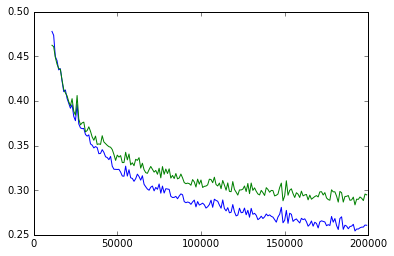

In [5]:
RunLogsticRegression()

step: 0, batch loss: 13.805705, train loss: 10.258060, train accuracy: 15.14%, validation loss: 10.282709, validation accuracy: 14.36%
step: 1000, batch loss: 1.089441, train loss: 1.937116, train accuracy: 61.77%, validation loss: 1.829677, validation accuracy: 63.04%
step: 2000, batch loss: 1.398630, train loss: 1.307650, train accuracy: 72.18%, validation loss: 1.209321, validation accuracy: 73.58%
step: 3000, batch loss: 0.755546, train loss: 1.053992, train accuracy: 76.98%, validation loss: 0.963534, validation accuracy: 78.34%
step: 4000, batch loss: 3.035974, train loss: 0.932110, train accuracy: 79.33%, validation loss: 0.856052, validation accuracy: 80.24%
step: 5000, batch loss: 0.743240, train loss: 0.849458, train accuracy: 81.05%, validation loss: 0.774065, validation accuracy: 82.04%
step: 6000, batch loss: 0.884534, train loss: 0.790727, train accuracy: 82.09%, validation loss: 0.716525, validation accuracy: 83.28%
step: 7000, batch loss: 0.662622, train loss: 0.740203,

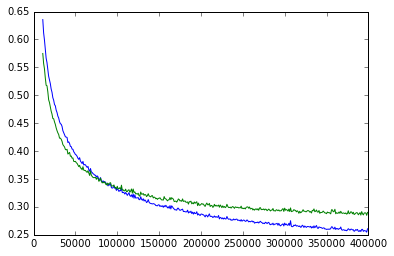

In [6]:
RunLogsticRegression(
    learning_rate=0.02,
    steps = 400 * 1000,
    l2_regularization_strength=0.1,
)

# Neural Network with LeRU and softmax

In [7]:
def RunNeuralNetwork(learning_rate = 0.01,
                     batch_size = 16,
                     steps = 100 * 1000,
                     sample = 5000,
                     dropout_keep_prob = 1.0,
                     hidden_sizes = [100, 75, 50]):
    graph = tf.Graph()
    sess = tf.Session(graph=graph)

    with graph.as_default():
        inputs = tf.placeholder(tf.float32, [None, image_size])
        labels = tf.placeholder(tf.float32, [None, num_classes])
        keep_prob = tf.placeholder(tf.float32)

        layer = inputs
        for hidden_size in hidden_sizes:
            input_size = layer.get_shape()[1].value
            weights = tf.Variable(tf.truncated_normal([input_size, hidden_size], stddev=0.1))
            biases = tf.Variable(tf.constant(0.1, shape=[hidden_size]))
            layer = tf.nn.relu(tf.matmul(layer, weights) + biases)
            if dropout_keep_prob < 1.0:
                layer = tf.nn.dropout(layer, keep_prob)

        input_size = layer.get_shape()[1].value
        weights = tf.Variable(tf.truncated_normal([input_size, num_classes], stddev=0.1))
        biases = tf.Variable(tf.constant(0.1, shape=[num_classes]))
        logits = tf.matmul(layer, weights) + biases
        cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, labels))

        # train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy)    
        train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
        
        correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

        # This must be called after all Variable definitions.
        init_variables = tf.initialize_all_variables()

    step_records = []
    train_losses = []
    validation_losses = []
    @contextlib.contextmanager
    def show_graph():
        try:
            yield
        finally:
            plt.plot(step_records, train_losses)
            plt.plot(step_records, validation_losses)
            plt.show()

    with show_graph(), sess.as_default():
        init_variables.run()

        for step in xrange(steps):
            batch_input, batch_label = mnist.train.next_batch(batch_size)
            sess.run(train_step, {inputs: batch_input, labels: batch_label, keep_prob: dropout_keep_prob})
            if step % sample == 0 or step == steps - 1:
                batch_entropy = sess.run(
                    cross_entropy,
                    {inputs: mnist.validation.images, labels: mnist.validation.labels, keep_prob: 1.0}
                )
                train_entropy, train_accuracy = sess.run(
                    (cross_entropy, accuracy),
                    {inputs: mnist.train.images, labels: mnist.train.labels, keep_prob: 1.0}
                )
                validation_entropy, validation_accuracy = sess.run(
                    (cross_entropy, accuracy),
                    {inputs: mnist.validation.images, labels: mnist.validation.labels, keep_prob: 1.0}
                )
                print 'step: %d, batch loss: %.4f, train loss: %f, train accuracy: %.2f%%, validation loss: %.4f, validation accuracy: %.2f%%' % (
                    step, batch_entropy, train_entropy, 100. * train_accuracy, validation_entropy, 100. * validation_accuracy)
                if train_entropy < 0.5:
                    step_records.append(step)
                    train_losses.append(train_entropy)
                    validation_losses.append(validation_entropy)

step: 0, batch loss: 2.3066, train loss: 2.308120, train accuracy: 10.55%, validation loss: 2.3066, validation accuracy: 10.64%
step: 5000, batch loss: 0.2587, train loss: 0.274207, train accuracy: 92.09%, validation loss: 0.2587, validation accuracy: 92.80%
step: 10000, batch loss: 0.1978, train loss: 0.203664, train accuracy: 94.11%, validation loss: 0.1978, validation accuracy: 94.40%
step: 15000, batch loss: 0.1509, train loss: 0.149528, train accuracy: 95.72%, validation loss: 0.1509, validation accuracy: 95.84%
step: 20000, batch loss: 0.1302, train loss: 0.119249, train accuracy: 96.56%, validation loss: 0.1302, validation accuracy: 96.50%
step: 25000, batch loss: 0.1253, train loss: 0.106434, train accuracy: 96.85%, validation loss: 0.1253, validation accuracy: 96.72%
step: 30000, batch loss: 0.1060, train loss: 0.082389, train accuracy: 97.65%, validation loss: 0.1060, validation accuracy: 97.28%
step: 35000, batch loss: 0.1032, train loss: 0.072574, train accuracy: 97.92%, va

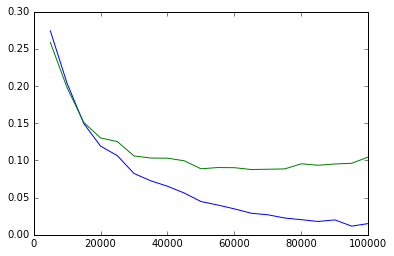

In [8]:
RunNeuralNetwork()

step: 0, batch loss: 2.4424, train loss: 2.445468, train accuracy: 7.24%, validation loss: 2.4424, validation accuracy: 6.62%
step: 5000, batch loss: 0.3394, train loss: 0.352611, train accuracy: 90.11%, validation loss: 0.3394, validation accuracy: 90.66%
step: 10000, batch loss: 0.2209, train loss: 0.232395, train accuracy: 93.10%, validation loss: 0.2209, validation accuracy: 93.46%
step: 15000, batch loss: 0.1780, train loss: 0.183670, train accuracy: 94.62%, validation loss: 0.1780, validation accuracy: 94.98%
step: 20000, batch loss: 0.1508, train loss: 0.152575, train accuracy: 95.44%, validation loss: 0.1508, validation accuracy: 95.86%
step: 25000, batch loss: 0.1375, train loss: 0.133160, train accuracy: 96.03%, validation loss: 0.1375, validation accuracy: 96.20%
step: 30000, batch loss: 0.1205, train loss: 0.114255, train accuracy: 96.61%, validation loss: 0.1205, validation accuracy: 96.60%
step: 35000, batch loss: 0.1165, train loss: 0.101848, train accuracy: 97.02%, vali

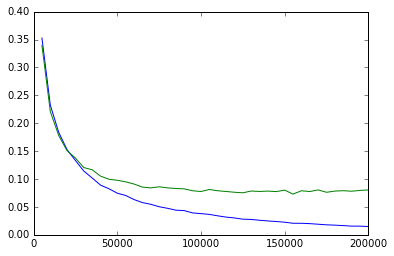

In [9]:
RunNeuralNetwork(
    dropout_keep_prob=0.5,
    steps = 200 * 1000,
    hidden_sizes = [200, 150, 100],
)

# Convolutional Network
- [Deep MNIST for Experts](https://www.tensorflow.org/versions/r0.9/tutorials/mnist/pros/index.html)
- [An example in tensorflow: convolutional.py](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/models/image/mnist/convolutional.py)

In [10]:
ConvConfig = collections.namedtuple('ConvConfig', ['patch', 'channel'])

default_conv_configs = [
    ConvConfig(patch=5, channel=32),
    ConvConfig(patch=5, channel=64),
]

image_width = 28
assert image_width * image_width == image_size

def RunConvolutionalNN(
    batch_size = 16,
    learning_rate = 0.01,
    steps = 50 * 1000,
    sample = 5000,
    conv_configs=default_conv_configs,
    fully_connect_sizes = [512],
    dropout_keep_prob = 1.0,
):
    graph = tf.Graph()
    sess = tf.Session(graph=graph)

    with graph.as_default():
        images = tf.placeholder(tf.float32, [None, image_size])
        labels = tf.placeholder(tf.float32, [None, num_classes])
        # keep_prob = tf.placeholder(tf.float32)

        layer = tf.reshape(images, [-1, image_width, image_width, 1], name='reshaped')
        print 'reshaped input shape:', layer.get_shape()
        for i in xrange(len(conv_configs)):
            config = conv_configs[i]
            weight_shape = [config.patch, config.patch, layer.get_shape()[-1].value, config.channel]
            weight = tf.Variable(tf.truncated_normal(weight_shape, stddev=0.1))
            conv = tf.nn.conv2d(layer, weight, strides=[1, 1, 1, 1], padding='SAME')
            bias = tf.Variable(tf.zeros([config.channel]))
            conv = tf.nn.relu(tf.nn.bias_add(conv, bias))

            # Is the order of relu and max_pool important?
            layer = tf.nn.max_pool(conv, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
            print 'conv layer.shape (%d):' % i, layer.get_shape()

        layer = tf.reshape(layer, [-1, 7 * 7 * 64])
        for i in xrange(len(fully_connect_sizes)):
          size = fully_connect_sizes[i]
          weight = tf.Variable(tf.truncated_normal([layer.get_shape()[1].value, size], stddev=0.1))
          bias = tf.Variable(tf.constant(0.1, shape=[size]))
          layer = tf.nn.relu(tf.matmul(layer, weight) + bias)
          print 'fully-connected.shape (%d):' % i, layer.get_shape()

        weight = tf.Variable(tf.truncated_normal([layer.get_shape()[1].value, num_classes], stddev=0.1))
        bias = tf.Variable(tf.constant(0.1, shape=[num_classes]))
        logits = tf.matmul(layer, weight) + bias

        cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, labels))

        # train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy)    
        train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
        
        correct_count = tf.reduce_sum(tf.cast(tf.equal(tf.argmax(logits, 1), tf.argmax(labels, 1)), tf.int32))

        init_variables = tf.initialize_all_variables()
        
    step_records = []
    train_losses = []
    validation_losses = []
    @contextlib.contextmanager
    def show_graph():
        try:
            yield
        finally:
            plt.plot(step_records, train_losses)
            plt.plot(step_records, validation_losses)
            plt.show()

    # This is important tosave RAM.
    def evaluate_in_batches(dataset):
        EVAL_BATCH_SIZE = 128
        size = dataset.images.shape[0]
        losses = []
        correct_sum = 0
        for start in xrange(0, size, EVAL_BATCH_SIZE):
            end = start + EVAL_BATCH_SIZE
            if end > size:
                end = size
            loss, correct = sess.run([cross_entropy, correct_count], {images: dataset.images[start:end], labels:dataset.labels[start:end]})
            losses.append(loss)
            correct_sum += correct
        return np.mean(losses), 1.0 * correct_sum / size

    with show_graph(), sess.as_default():
        init_variables.run()

        for step in xrange(steps):
            batch_images, batch_labels = mnist.train.next_batch(batch_size)
            sess.run(train_step, {images: batch_images, labels: batch_labels})
            if step % sample == 0:
                batch_loss = cross_entropy.eval({images: batch_images, labels: batch_labels})
                print 'step: %d, batch loss: %f' % (step, batch_loss)
                train_loss, train_accuracy = evaluate_in_batches(mnist.train)
                validation_loss, validation_accuracy = evaluate_in_batches(mnist.validation)
                print 'step: %d, train loss: %f, train accuracy: %.2f%%, validation loss: %.4f, validation accuracy: %.2f%%' % (
                    step, train_loss, 100. * train_accuracy, validation_loss, 100. * validation_accuracy)
                if train_loss < 0.5:
                    step_records.append(step)
                    train_losses.append(train_loss)
                    validation_losses.append(validation_loss)


reshaped input shape: (?, 28, 28, 1)
conv layer.shape (0): (?, 14, 14, 32)
conv layer.shape (1): (?, 7, 7, 64)
fully-connected.shape (0): (?, 512)
step: 0, batch loss: 3.187042
step: 0, train loss: 3.203293, train accuracy: 10.78%, validation loss: 3.2104, validation accuracy: 11.06%
step: 5000, batch loss: 0.014325
step: 5000, train loss: 0.040486, train accuracy: 98.75%, validation loss: 0.0469, validation accuracy: 98.66%
step: 10000, batch loss: 0.009346
step: 10000, train loss: 0.026283, train accuracy: 99.20%, validation loss: 0.0407, validation accuracy: 98.90%
step: 15000, batch loss: 0.005426
step: 15000, train loss: 0.016398, train accuracy: 99.52%, validation loss: 0.0362, validation accuracy: 99.00%
step: 20000, batch loss: 0.001204
step: 20000, train loss: 0.007087, train accuracy: 99.81%, validation loss: 0.0316, validation accuracy: 99.12%
step: 25000, batch loss: 0.066502
step: 25000, train loss: 0.006818, train accuracy: 99.79%, validation loss: 0.0382, validation accu

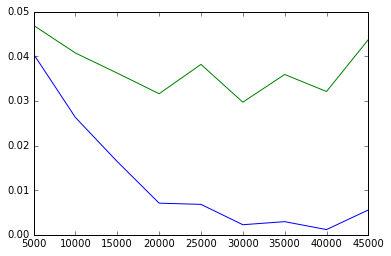

In [11]:
RunConvolutionalNN()